In [ ]:
# created by G Oldford
# purpose: plots reporting model perf using LH and SST 
#
# data in: csv's of stats from python analysis app run on server
#          manually input mean and std found in figs produced by Pyap
# data out: 

# notes: 
#  - tried cdat (won't install easily on windows)
#  - tried custom code snippet from ycopin (see below)
#  - tried xcdat (not sure there is a taylor diag)
#  - tried SkillMetrics (won't install via pip or conda, but cloned repo locally)
#  - May 28 - SSS is poor.To do: Two plot options - choose one. Add target plot. Add SST buoy data

# last modified July 28 2023
# to do: extract the plotting section of target code so I can overly additional datasets
# revise the taylor code and test with overlays of second or third dataset
# revise so panels / gridspec can be used or subplots
# dump the target and taylor code to python scripts


In [ ]:
!python --version

In [35]:
import scipy.io
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import sys
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.colors as clr
from matplotlib.ticker import ScalarFormatter
import math
from math import log10, floor
from array import array
import numbers
from matplotlib.lines import Line2D
import warnings
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [10]:
# functions to load LH and buoy data
def get_lh_stats(LH_scores, modelrun, augment_rmse, var):
    
    lh_stats_taylor = []
    lh_stats_target = []

    for lh in LH_scores[modelrun].keys():
        
        pears = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['pearson']
        mod_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_mod']
        obs_stdev = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['stdev_obs']

        mod_norm_stdev = mod_stdev / obs_stdev

        crmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['crmse']

        ncrmse = crmse / obs_stdev   

        # stats needed for taylor
        lh_stats_taylor.append([lh,
                                obs_stdev,
                                mod_stdev,
                                mod_norm_stdev,
                                crmse,
                                ncrmse,
                                pears])

        # stats needed for target
        rmse = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['rmse']
        bias = LH_scores[modelrun][lh]['filt_interp_data']['scores'][var]['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                nrmse = nrmse * -1
                crmse = crmse * -1
                ncrmse = ncrmse * -1

        lh_stats_target.append([lh,
                                rmse,
                                crmse,
                                nrmse,
                                ncrmse,
                                bias
                               ])

    lh_stats_taylor_np = np.array(lh_stats_taylor)
    lh_stats_target_np = np.array(lh_stats_target)
    
    
    return(lh_stats_taylor_np, lh_stats_target_np)


def get_SSTbuoy_stats (SSTbuoy_scores, modelrun, augment_rmse, buoy_list):
    buoy_stats_taylor = []
    buoy_stats_target = []

    for buoy in SSTbuoy_scores[modelrun].keys():

        if buoy == "C46134_2001-02_2016-12.nc":
            buoy_bettername = '46134'
        elif buoy == "C46131_1992-10_2021-01.nc":
            buoy_bettername = '46131'
        elif buoy == "C46146_1992-03_2022-06.nc":
            buoy_bettername = '46146'
        elif buoy == "C46182_1989-09_1991-11.nc":
            buoy_bettername = '46182'
        else:
            buoy_bettername = buoy
        
        if (buoy_bettername not in buoy_list):
            continue
        
        obs_stdev = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['stdev_obs']
        mod_stdev = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['stdev_mod']
        mod_norm_stdev = mod_stdev / obs_stdev
        crmse = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['crmse']
        ncrmse = crmse / obs_stdev
        pears = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['pearson']
        
        # for taylors
        buoy_stats_taylor.append([buoy_bettername,
                                  obs_stdev,
                                  mod_stdev,
                                  mod_norm_stdev,
                                  crmse,
                                  ncrmse,
                                  pears]) 
        # for target
        rmse = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['rmse']
        bias = SSTbuoy_scores[modelrun][buoy]['filt_interp_data']['scores']['bias']
        nrmse = rmse / obs_stdev

        if augment_rmse == True:
            if (mod_stdev - obs_stdev) < 0:
                rmse = rmse * -1
                crmse = crmse * -1
                nrmse = nrmse * -1
                ncrmse = ncrmse * -1

        buoy_stats_target.append([buoy_bettername,
                                  rmse,
                                  crmse,
                                  nrmse,
                                  ncrmse,
                                  bias])

    # np is easier
    buoy_stats_taylor_np = np.array(buoy_stats_taylor)
    buoy_stats_target_np = np.array(buoy_stats_target)
    
    return(buoy_stats_taylor_np, buoy_stats_target_np)



### TARGET figures, diagrams
# SM code pasted below (instead of difficult to follow separate .py)

# import sys
# !{sys.executable} -m pip3 install skillmetrics

# functions required for SkillMetrics
# functions
def find_exp(number) -> int:
    base10 = log10(abs(number))
    return floor(base10)

def use_sci_notation(value):
    '''
    Boolean function to determine if scientific notation to be used for value
 
    Input:
    Value : value to be tested
 
    Return:
        True if absolute value is > 100 or < 1.e-3
        False otherwise

    Author: Peter A. Rochford
        Symplectic, LLC

    Created on May 10, 2022
    '''
    if (abs(value)>0 and abs(value) < 1e-3):
        return True
    else:
        return False
    
def blank_at_zero(tick,label):
    tolerance = 1.e-14
    if type(tick) is np.ndarray:
        index = np.where(abs(tick) < tolerance)
    else:
        temp = np.array(tick)
        index = np.where(abs(temp) < tolerance)
        del temp

    if np.size(index) == 0:
        raise ValueError('Array must span negative to positive values tick=',tick)
    else:
        index = index[0].item()
        label[index] = ''
        
def get_axis_tick_label(value):
    '''
    Get label for number on axis without trailing zeros.
    59.400000000000006
    will be returned as a string 
    '59.4'
    '''
    number_digits = 0
    if not use_sci_notation(value):
        label = str(value)
        
        # Get substring after period
        trailing = label.partition('.')[2]
        number_sigfig = 0
        if len(trailing) > 0:
            # Find number of non-zero digits after decimal
            number_sigfig = 1
            before = trailing[0]
            number_digits = 1
            go = True
            while go and number_digits < len(trailing):
                if trailing[number_digits] == before:
                    number_sigfig = number_digits - 1
                    if(number_sigfig > 5): go = False
                else:
                    before = trailing[number_digits]
                    number_sigfig = number_digits - 1
                number_digits+=1
    
        if number_digits == len(trailing): number_sigfig = number_digits

        # Round up the number to desired significant figures
        label = str(round(value, number_sigfig))
    else:
        label = "{:.1e}".format(value)

    return label

def pol2cart(phi, rho):
    '''
    make polar coords cartesian
    
    INPUTS:
    phi : polar angle counter-clockwise from x-axis in radians
    rho : radius
    
    OUTPUTS:
    x   : Cartesian x-coordinate
    y   : Cartesian y-coordinate
    '''

    x = np.multiply(rho, np.cos(phi))
    y = np.multiply(rho, np.sin(phi))
    return x, y


In [238]:
## TARGET DIAGRAM CODE
### GET AXES #####
# function get_target_diagram_axes(RMSDs,Bs,option) -->
def get_target_diagram_axes(ax, options):
      
    # unused?
    circlecols = options['circlecols'] 
    
    equalaxes = options['equalaxes']
    normalized = options['normalized']
    ticklabcolor= options['ticklabcolor']
    axesedgecolor = options['axesedgecolor']
    overlay = options['overlay']
    
    bias_label = options['bias_label']
    RMSD_label = options['RMSD_label']
    b_lab_rot = options['b_lab_rot']
    rmsd_lab_rot = options['rmsd_lab_rot']
    b_lab_pos_yoffset = options['b_lab_pos_yoffset']
    b_lab_pos_xoffset = options['b_lab_pos_xoffset']
    rmsd_lab_pos_yoffset = options['rmsd_lab_pos_yoffset']
    rmsd_lab_pos_xoffset = options['rmsd_lab_pos_xoffset']
    axismax = options['axismax']
    ticks = options['ticks']
    xticklabelpos = options['xticklabelpos']
    yticklabelpos = options['yticklabelpos']
    yticklabelpos = options['yticklabelpos'] 
    o_circles = options['o_circles']
    #'circlelinespec':'k--',
    circlelinespec = options['circlelinespec']
    circlestyle = options['circlestyle']
    circlelinewidth = options['circlelinewidth']
    circlecolor = options['circlecolor']
    obsuncertainty = options['obsuncertainty']
    
    foundmax = 1 if axismax != 0.0 else 0
    if foundmax == 0:
        # Axis limit not specified
        maxx = np.amax(np.absolute(x))
        maxy = np.amax(np.absolute(y))
    else:
        # Axis limit is specified
        maxx = axismax
        maxy = axismax

    # Determine default number of tick marks
    xtickvals = ticker.AutoLocator().tick_values(-1.0*maxx, maxx)
    ytickvals = ticker.AutoLocator().tick_values(-1.0*maxy, maxy)
    nxticks = np.sum(xtickvals > 0)
    nyticks = np.sum(ytickvals > 0)

    # Set default tick increment and maximum axis values
    if foundmax == 0:
        maxx = xtickvals[-1]
        maxy = ytickvals[-1]
        axismax = max(maxx, maxy)

    # Check if equal axes requested
    if equalaxes == 'on':
        if maxx > maxy:
            maxy = maxx
            nyticks = nxticks
        else:
            maxx = maxy
            nxticks = nyticks

    # Convert to integer if whole number
    if type(maxx) is float and maxx.is_integer(): maxx = int(round(maxx))
    if type(maxx) is float and maxy.is_integer(): maxy = int(round(maxy))
    minx = -maxx; miny = -maxy

    # Determine tick values
    if len(ticks) > 0:
        xtick = ticks; ytick = ticks
    else:
        tincx = maxx/nxticks; tincy = maxy/nyticks
        xtick = np.arange(minx, maxx+tincx, tincx)
        ytick = np.arange(miny, maxy+tincy, tincy)

    # Assign tick label positions
    if len(xticklabelpos) == 0:
        xticklabelpos= xtick
    if len(yticklabelpos) == 0:
        yticklabelpos= ytick

    #define x offset
    thexoffset = find_exp(maxx)

    if use_sci_notation(maxx): 
        ixsoffset = True
        xsoffset_str = "$\tx\mathdefault{10^{"+ str(thexoffset) +"}}\mathdefault{}$"
    else:
        ixsoffset = False
        xsoffset_str = 'None'

    theyoffset = find_exp(maxy)
    if use_sci_notation(maxy): 
        iysoffset = True
        ysoffset_str = "$\tx\mathdefault{10^{"+str(theyoffset)+"}}\mathdefault{}$"
    else:
        iysoffset = False
        ysoffset_str = 'None'

    # Set tick labels using provided tick label positions
    xlabel =[]; ylabel = [];

    # Set x tick labels
    for i in range(len(xtick)):
        index = np.where(xticklabelpos == xtick[i])
        if len(index) > 0:
            thevalue = xtick[i]
            if ixsoffset: 
                thevalue = xtick[i] * (10**(-1*thexoffset))
                label = get_axis_tick_label(thevalue)
                xlabel.append(label)
            else:
                label = get_axis_tick_label(xtick[i])
                xlabel.append(label)
        else:
            xlabel.append('')

    # Set tick labels at 0 to blank
    # print(xtick)
    blank_at_zero(xtick,xlabel)

    # Set y tick labels
    for i in range(len(ytick)):
        index = np.where(yticklabelpos == ytick[i])
        if len(index) > 0:
            thevalue = ytick[i]
            if iysoffset: 
                thevalue = ytick[i] * (10**(-1*theyoffset)) 
                label = get_axis_tick_label(thevalue)
                ylabel.append(label)
            else:
                label = get_axis_tick_label(ytick[i])
                ylabel.append(label)
        else:
            ylabel.append('')

    # Set tick labels at 0 to blank
    blank_at_zero(ytick,ylabel)

    # Store output variables in data structure
    axes = {}
    axes['xtick'] = xtick
    axes['ytick'] = ytick
    axes['xlabel'] = xlabel
    axes['ylabel'] = ylabel
    axes['xoffset'] = xsoffset_str
    axes['yoffset'] = ysoffset_str
    # END function get_target_diagram_axes


    #### Overlay circles ####
    # function overlay_target_diagram_circles(ax: matplotlib.axes.Axes, option: dic) -->
    theta = np.arange(0, 2*np.pi, 0.01)
    unit = np.ones(len(theta))

    # 1 - reference circle if normalized
    if normalized == 'on':
        rho = unit
        X, Y = pol2cart(theta, rho)
        ax.plot(X, Y, 'k', 'LineWidth', circleLineWidth)

    # Set range for target circles
    if normalized == 'on':
        circles = [.5, 1]
    else:
        if o_circles is None:
            circles = [axismax * x for x in [.7, 1]]
        else:
            circles = np.asarray(o_circles)
            index = np.where(circles <= axismax)
            circles = [o_circles[i] for i in index[0]]

    # 2 - secondary circles
    for c in circles:
        rho = c * unit
        X, Y = pol2cart(theta, rho)
        ax.plot(X, Y, linestyle=circlestyle,
                color=circlecolor,
                linewidth=circlelinewidth)
    del c

    # 3 - Observational Uncertainty threshold
    if obsuncertainty > 0:
        rho = obsuncertainty * unit
        X, Y = pol2cart(theta, rho)
        ax.plot(X, Y, '--b')
    # END function overlay_target_diagram_circles


    # Modify axes for target diagram (no overlay)
    # if option['overlay'] == 'off':
    #     axes_handles = plot_target_axes(ax, axes)
    # function plot_target_axes -->   
    if overlay == 'off':    
        axes_handles = []
        fontFamily = rcParams.get('font.family')

        # Center axes location by moving spines of bounding box
        # Note: Center axes location not available in matplotlib
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Make axes square
        ax.set_aspect('equal')

        # Set new ticks and tick labels
        ax.set_xticks(axes['xtick'])
        ax.set_xticklabels(axes['xlabel'], fontfamily=fontFamily, color=ticklabcolor)
        ax.set_yticks(axes['ytick'])
        ax.set_yticklabels(axes['ylabel'], fontfamily=fontFamily, color=ticklabcolor)

        # Set axes limits
        axislim = [axes['xtick'][0], axes['xtick'][-1], axes['ytick'][0], axes['ytick'][-1]]
        ax.set_xlim(axislim[0:2])
        ax.set_ylim(axislim[2:])

        # Label x-axis
        fontSize = matplotlib.rcParams.get('font.size')
        xpos = axes['xtick'][-1] + 2*axes['xtick'][-1]/30
        ypos = axes['xtick'][-1]/30
        if axes['xoffset'] == 'None':
           ax.set_xlabel(RMSD_label, fontsize = fontSize, rotation=rmsd_lab_rot)
        else:
           ax.set_xlabel(RMSD_label + '\n(' + axes['xoffset'] + ')', fontsize = fontSize, rotation=rmsd_lab_rot)
        xlabelh = ax.xaxis.get_label()
        xlabelh.set_horizontalalignment('left')
        ax.xaxis.set_label_coords(xpos+rmsd_lab_pos_xoffset, ypos+rmsd_lab_pos_yoffset, transform=ax.transData)
        ax.tick_params(axis='x', direction='in') # have ticks above axis

        # Label y-axis
        xpos = 0
        ypos = axes['ytick'][-1] + 2*axes['ytick'][-1]/30
        if axes['yoffset'] == 'None':        
            ax.set_ylabel(bias_label + ' ', fontsize = fontSize, rotation=b_lab_rot)
        else:
            ax.set_ylabel(bias_label + ' ' + '(' + axes['yoffset'] + ')', fontsize = fontSize, rotation=b_lab_rot)

        ylabelh = ax.yaxis.get_label()
        ylabelh.set_horizontalalignment('center')
        ax.yaxis.set_label_coords(xpos+b_lab_pos_xoffset, ypos+b_lab_pos_yoffset, transform=ax.transData)
        ax.tick_params(axis='y', direction='in') # have ticks on right side of axis

        # Set axes line width
        lineWidth = rcParams.get('lines.linewidth')
        ax.spines['left'].set_linewidth(lineWidth)
        ax.spines['bottom'].set_linewidth(lineWidth)

        ax.spines['left'].set_edgecolor(axesedgecolor)
        ax.spines['bottom'].set_edgecolor(axesedgecolor)

    # END function plot_target_axes --> 
    return ax #get_target_diagram_axes

###########################
##### plot the markers ####

def plot_target_data(ax, RMSDs, Bs, options):

    # Plot data points
    # lowcase = markerdisplayed.lower()
    # if lowcase == 'marker':
    #     plot_pattern_diagram_markers(ax,RMSDs,Bs,option)
    # elif lowcase == 'colorbar':
    #     plot_pattern_diagram_colorbar(ax,RMSDs,Bs,RMSDz,option)
    # else:
    #     raise ValueError('Unrecognized option: ' + 
    #                      markerdisplayed)

    # function plot_pattern_diagram_markers (ax,RMSDs,Biases,option) -->
    # must change X to RMSDs, Y to Biases

    x = RMSDs
    y = Bs 
    
    # Set font and marker size
    fontSize = matplotlib.rcParams.get('font.size') 

    o_markerlabel = options['o_markerlabel']
    o_markers = options['o_markers']
    o_markerstyle = options['o_markerstyle'] # added by GO - "font" / "symbol"
    o_markersize = options['o_markersize']
    o_markersymbol = options['o_markersymbol'] #'+','o','x','s','d','^','v','p','h','*'
    o_markercolor = options['o_markercolor'] # single color to use for all markers (Default: None)
    o_markercolors = options['o_markercolors'] # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
#                             or None. If None or 'markerlegend' == 'on' then
#                             considers only the value of 'markercolor'. (Default: None)
    o_markerlabelcolor = options['o_markerlabelcolor']
    markerdisplayed = options['markerdisplayed']
    markerobs = options['markerobs']
    markerlegend = options['markerlegend']
    alpha = options['alpha']
    stylebias = options['stylebias']
    numberpanels = options['numberpanels']
    face = options['face']
    edge = options['edge']
    cmap = options['cmap']
    cmap_vmin = options['cmap_vmin']
    cmap_vmax = options['cmap_vmax']
    cmap_marker = options['cmap_marker']
    cmapzdata = options['cmapzdata']
    colframe = options['colframe']
    colormap = options['colormap']
    labelweight = options['labelweight']
    locationcolorbar = options['locationcolorbar']
    axismax = options['axismax']
    
    target_options_file = options['target_options_file']
    titlecolorbar = options['titlecolorbar']

    # Check enough labels provided if markerlabel provided. Not a problem if labels
    # provided via the markers option.
    numberLabel = len(o_markerlabel)
    if numberLabel > 0:
        if isinstance(o_markerlabel, list) and numberLabel < len(RMSDs):
            raise ValueError('Insufficient number of marker labels provided.\n' +
                             'target: No. labels=' + str(numberLabel) + ' < No. markers=' +
                             str(len(RMSDs)) + '\n' +
                             'taylor: No. labels=' + str(numberLabel+1) + ' < No. markers=' +
                             str(len(RMSDs)+1))
        elif isinstance(o_markerlabel, dict) and numberLabel > 70: # what is this? GLO why 70?
            raise ValueError('Insufficient number of marker labels provided.\n' +
                             'target: No. labels=' + str(numberLabel) + ' > No. markers= 70')

    if markerlegend == 'on':
        # Check that marker labels have been provided
        if o_markerlabel == '' and o_markers == None:
            raise ValueError('No marker labels provided.')

        # Plot markers of different color and symbols with labels displayed in a legend
        limit = axismax
        hp = ()
        rgba = None

        if o_markers is None:

            # Define default markers (function)
    #         marker, markercolor = get_default_markers(X, option)
            #get_default_markers:
    #         alpha = option['alpha']

            # Define list of marker symbols and colros
            kind = ['+','o','x','s','d','^','v','p','h','*']
            colorm = ['r','b','g','c','m','y','k','gray']
            if len(RMSDs) > 80:
                print('You must introduce new markers to plot more than 70 cases.')
                print('The ''marker'' character array need to be extended inside the code.')

            if len(RMSDs) <= len(kind):
                # Define markers with specified color
                marker = []
                markercolor = []
                if o_markercolor is None:
                    for i, color in enumerate(colorm):
                        rgba = clr.to_rgb(color) + (alpha,)
                        marker.append(kind[i] + color)
                        markercolor.append(rgba)
                else:
                    rgba = clr.to_rgb(o_markercolor) + (alpha,)
                    for symbol in kind:
                        marker.append(symbol + o_markercolor)
                        markercolor.append(rgba)
            else:
                # Define markers and colors using predefined list
                marker = []
                markercolor = []
                for color in colorm:
                    for symbol in kind:
                        marker.append(symbol + color)
                        rgba = clr.to_rgb(color) + (alpha,)
                        markercolor.append(rgba)
            # END get_default_markers


            # Plot markers at data points
            labelcolor = []
            markerlabel = []
            for i, xval in enumerate(RMSDs):
                if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                    h = ax.plot(RMSDs[i],
                                Bs[i],
                                marker[i], 
                                markersize = o_markersize,
                                markerfacecolor = markercolor[i],
                                markeredgecolor = markercolor[i][0:3] + (1.0,),
                                markeredgewidth = 1)
                    hp += tuple(h)
                    labelcolor.append(o_markerlabelcolor)
                    markerlabel.append(o_markerlabel[i])

        # if there's an o_markers dictionary
        else:
            # Obtain markers from option['markers']
            #labels, labelcolor, marker, markersize, markerfacecolor, markeredgecolor = \
                #get_single_markers(option['markers'])

            #get_single_markers -->
            if o_markers is None:
                raise ValueError("Empty dictionary provided for option['markers']")

            labelcolor = []
            marker = []
            markerfacecolor = []
            markeredgecolor = []
            markerlabel = []
            markersize = []
            markeredgewidth = []

    #         if o_markerstyle == "font":
    #             marker_style.update(markeredgecolor="none", markersize=15)

            # Iterate through keys in dictionary
            for key in o_markers:
                color = o_markers[key]['facecolor']
                symbol = o_markers[key]['symbol']

                if o_markerstyle != "font":
                    SymbolColor = symbol + color
                    marker.append(SymbolColor)
                else:
                    marker.append(symbol)
                    fontFamily = rcParams.get('font.family')

                markersize.append(o_markers[key]['size'])
                markerfacecolor.append(color)
                markeredgecolor.append(o_markers[key]['edgecolor'])
                markeredgewidth.append(o_markers[key]['edgewidth'])
                markerlabel.append(key) # store label
                labelcolor.append(o_markers[key]['labelcolor'])
            # end get_single_markers

            # Plot markers at data points
            for i, xval in enumerate(RMSDs):
                if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                    h = ax.plot(RMSDs[i],
                                Bs[i],
                                marker=marker[i],
                                markersize = markersize[i],
                                markerfacecolor = markerfacecolor[i],
                                markeredgecolor = markeredgecolor[i],
                                markeredgewidth = markeredgewidth[i])
                    hp += tuple(h)
                    #markerlabel.append(labels[i])

#         # Add legend
#         if len(markerlabel) == 0:
#             warnings.warn('No markers within axis limit ranges.')
#         else:

            #add_legend(markerlabel, labelcolor, option, rgba, markerSize, fontSize, hp)          
            # add_legend --> 
#             if type(markerlabel) is list:

#                 # Check for empty list of plot handles
#                 if len(hp) == 0:
#                     raise ValueError('Empty list of plot handles')
#                 elif len(hp) != len(markerlabel):
#                     raise ValueError('Number of labels and plot handle do not match: ' +
#                                      str(len(markerlabel)) + ' != ' + str(len(hp)))

#                 # Add legend using labels provided as list
#                 if len(markerlabel) <= 6:
#                     # Put legend in a default location
#                     markerlabel_tu = tuple(markerlabel)
#                     leg = plt.legend(hp, markerlabel_tu, loc = 'upper right',
#                                          fontsize = fontSize, numpoints=1,
#                                          bbox_to_anchor=(1.2,1.0))
#                 else:
#                     # Put legend to right of the plot in multiple columns as needed

#                     nmarkers = len(markerlabel)
#                     ncol = int(math.ceil(nmarkers / 15.0))
#                     markerlabel_tu = tuple(markerlabel)

#                     # Shift figure to include legend
#                     #plt.gcf().subplots_adjust(right=0.6)

#                     # Plot legend of multi-column markers
#                     # Note: do not use bbox_to_anchor as this cuts off the legend
#                     if circlelinespec != None:
#                         loc = (1.2, 0.25)
#                     else:    
#                         #loc = (1.1, 0.25)
#                         loc = (1.1, 0.75)

#                     leg = plt.legend(hp, markerlabel_tu, loc = loc, fontsize = fontSize,
#                                      numpoints=1, ncol = ncol)

#             elif type(markerlabel) is dict:

#                 # Add legend using labels provided as dictionary

#                 # Define legend elements
#                 legend_elements = []
#                 for key, value in markerlabel.items():
#                     legend_object = Line2D([0], 
#                                            [0], 
#                                            marker='.', 
#                                            markersize = markerSize,
#                                            markerfacecolor = rgba,
#                                            markeredgecolor = value,
#                                            label=key,
#                                            linestyle='')
#                     legend_elements.append(legend_object)

#                 # Put legend in a default location
#                 leg = plt.legend(handles=legend_elements, loc = 'upper right',
#                                      fontsize = fontSize, numpoints=1,
#                                      bbox_to_anchor=(1.2,1.0))

#                 if numberpanels != None and numberpanels == 2:
#                     # add padding so legend is not cut off
#                     plt.tight_layout(pad=1)
#             else:
#                 raise Exception('markerLabel type is not a list or dictionary: ' + 
#                                 str(type(markerlabel)))

#             # Set color of text in legend
#             for i, text in enumerate(leg.get_texts()):
#                 text.set_color(labelcolor[i])
            # end add_legend

    # if no legend        
    else:
        # Plot markers as dots of a single color with accompanying labels

        # Plot markers at data points
        limit = axismax

        # Define edge and face colors of the markers
        #                                             default_key, dict_key, key_key
        #edge_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'edge')
        # get_from_dict_or_default ->
        if o_markercolors is None:
            edge_color = o_markercolor
        elif edge is None:
            edge_color = o_markercolor
        elif edge != None:
            edge_color = edge
        # end get_from_dict_or_default

        if edge_color is None: edge_color = 'r'

        #face_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'face')
        # get_from_dict_or_default ->
        if o_markercolors is None:
            face_color = o_markercolor
        elif face is None:
            face_color = o_markercolor
        elif face != None:
            face_color = face
        # end get_from_dict_or_default

        if face_color is None: face_color = edge_color
        face_color = clr.to_rgb(face_color) + (alpha,)

        labelcolor = []
        for i in range(len(RMSDs)):
            xval, yval = RMSDs[i], Bs[i]
            if abs(xval) <= limit and abs(yval) <= limit:
                ax.plot(xval, yval, o_markersymbol,markersize=o_markersize, markerfacecolor=face_color,markeredgecolor=edge_color)
                labelcolor.append(o_markerlabelcolor)

                # Check if marker labels provided
                if type(o_markerlabel) is list:
                    # Label marker
                    ax.text(xval, yval, o_markerlabel[i],color=o_markerlabelcolor,verticalalignment='bottom',horizontalalignment='right',fontsize=fontSize)

            del i, xval, yval

        # Add legend if labels provided as dictionary
#         marker_label_color = clr.to_rgb(edge_color) + (alpha,)
#         if type(o_markerlabel) is dict:
#             add_legend(o_markerlabel, labelcolor, option, marker_label_color, markerSize, fontSize)
            
    return ax

### Read the data

SalishSea1500-RUN216


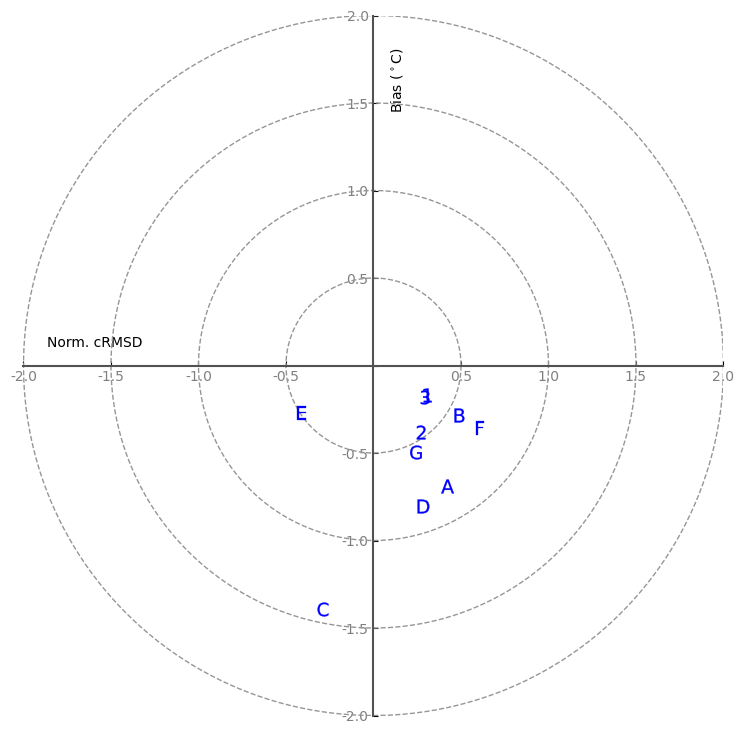

In [209]:

## streamline the above
modelruns_info = {#'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
                  #                         'colour': 'b', 
                  #                         'shortcode': 'RUN203'}, 
                     'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
                                           'colour': 'b', 
                                           'shortcode': 'RUN216'}
                 }

buoy_list = ['46131', '46134', '46146'] # excluding many of these
                     

# 'augment' rmse for target as per Kärnä et al 2021
# ie rmse < 0 if sig_mod - sig_obs < 0
augment_rmse = True

# fig setup
fig_dim_1 = 20
fig_dim_2 = 20
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))
#ax = plt.gca()
#gs = gridspec.GridSpec(1, 6)
#ax = plt.subplot(gs[:3])
ax = fig.add_subplot(2,2,1)
# ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
# fig.add_subplot(ax)

ax = read_data_and_plot_target(ax, modelruns_info, buoy_list)

In [217]:
def read_data_and_plot_target(ax, modelruns_info, buoy_list):
    
    # set up axes
    axismax = 2
    options = {
        'ticklabcolor':'#808080',
        'axesedgecolor': '#525252',
        'bias_label': "Bias ($^\circ$C)",
        'RMSD_label': "Norm. cRMSD",
        'b_lab_rot': 90,
        'rmsd_lab_rot':0,
        'b_lab_pos_yoffset': -0.5,
        'b_lab_pos_xoffset': 0.18,
        'rmsd_lab_pos_yoffset': 0.1,
        'rmsd_lab_pos_xoffset': -4,
        'axismax': axismax,
        'ticks': [],
        'xticklabelpos': [],
        'yticklabelpos': [],
        'normalized': 'off',
        'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
        'o_circles': [0.5,1,1.5,2.0], # radii of circles to draw
        #'circlelinespec':'k--',
        'circlelinespec':circlelinespec,
        'circlestyle': circlelinespec[1:], # circlelinespec by default
        'circlelinewidth': 1, # rcParams.get('lines.linewidth')
        'circlecolor': '#969696', #grey'
        'obsuncertainty': 0,
        'equalaxes': 'on',
        'overlay': 'off'
    }
    
    ax = get_target_diagram_axes(ax, options)
    
    for run in modelruns_info.keys():
        print(run)
        path1 = modelruns_info[run]['path']
        shortcode = modelruns_info[run]['shortcode']
        colour_m = modelruns_info[run]['colour']

        # get data
        LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
        LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             
        
        var = "temperature"
        lh_stats_taylor_T_np, lh_stats_target_T_np = get_lh_stats(LH_scores, run, augment_rmse, var)
        var = "salinity"
        lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, run, augment_rmse, var)

        # SST buoy data
        SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
        #print(os.path.join(path1,SSTbuoy_pic_data)
        SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

        # looks like:
        # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
        # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
        buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
        SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_T_np,buoy_stats_taylor_np))
        SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_T_np,buoy_stats_target_np))
        
        Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
        RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

        # plot markers
        msize = 8
        facecolor1 = colour_m
        facecolor2 = colour_m
        edgecolor1 = colour_m
        edgecolor2 = colour_m
        medgew1 = 0.2
        medgew2 = 0.2
                     
        # set up markers and related options
        o_markers = {'Active Pass': {#'symbol':'1',
                                 'symbol':r'$\mathdefault{A}$',
                                 'size': msize,
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 'Cape Mudge': {#'symbol':'2',
                                 'symbol':r'$\mathdefault{B}$',
                                 'size': msize,
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 'Chrome Is.': {#'symbol':'3',
                                 'symbol':r'$\mathdefault{C}$',
                                 'size': msize,
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 'Entrance Is.': {#'symbol':'4',
                                 'symbol':r'$\mathdefault{D}$',
                                 'size': msize,
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 'Race Rocks': {#'symbol':'+',
                                 'symbol':r'$\mathdefault{E}$',
                                 'size': msize,
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 'Sheringham Pt.': {#'symbol':'x',
                                 'symbol':r'$\mathdefault{F}$',
                                 'size': msize, #x's look too big
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 'Sisters Islets': {#'symbol':'o',
                                    'symbol':r'$\mathdefault{G}$',
                                 'size': msize,
                                 'facecolor': facecolor1,
                                 'edgecolor': edgecolor1,
                                 'edgewidth': medgew1,
                                'labelcolor': colour_m},
                 # SST / wave buoys
    #              'ptaw1': {#'symbol':'o',
    #                         'symbol':r'$\mathdefault{7}$',
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              'ptww1': {#'symbol':'D',
    #                         'symbol':"$8$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              'tcnw1': {#'symbol':'^',
    #                         'symbol':"$9$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              '46087': {#'symbol':'d',
    #                         'symbol':"$4$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              '46088': {#'symbol':'H',
    #                         'symbol':"$5$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
                 '46131': {#'symbol':'p',
                            'symbol':"$1$",
                                 'size': msize,
                                 'facecolor': facecolor2,
                                 'edgecolor': edgecolor2,
                                 'edgewidth': medgew2,
                                'labelcolor': colour_m},
                 '46146': {#'symbol':'v',
                            'symbol':"$3$",
                                 'size': msize,
                                 'facecolor': facecolor2,
                                 'edgecolor': edgecolor2,
                                 'edgewidth': medgew2,
                                'labelcolor': colour_m},
    #              'neaw1': {#'symbol':'h',
    #                         'symbol':"$6$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
                 '46134': {#'symbol':'h',
                            'symbol':"$2$",
                                 'size': msize,
                                 'facecolor': facecolor2,
                                 'edgecolor': edgecolor2,
                                 'edgewidth': medgew2,
                                'labelcolor': colour_m}
                }


        o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                            'Race Rocks', 'Sheringham Pt.', 'Sisters Islets',
            #                 'ptaw1', 'ptww1','tcnw1','46087','46088',
                             '46131','46146',
            #                  'neaw1',
                             '46134']
        

        options = {
            # markers and marker styles etc
            'axismax': axismax,
            'o_markerlabel': o_markerlabel,
            'o_markers': o_markers,
            'o_markerstyle': "font", # added by GO - "font" / "symbol"
            'o_markersize': 8, 
            'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
            'o_markercolor': 'b',  # single color to use for all markers (Default: None)
            'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
        #                             or None. If None or 'markerlegend' == 'on' then
        #                             considers only the value of 'markercolor'. (Default: None)

            'o_markerlabelcolor': 'k',
            'markerdisplayed':'marker', # marker / colorbar
            'markerobs': 'none',
            'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
            'alpha': 1,
            'stylebias': '-.',
            'numberpanels': None,
            'face': None, # face colors'
            'edge': None, 
            'cmap': 'jet',
            'cmap_vmin': None,
            'cmap_vmax': None,
            'cmap_marker': 'd',
            'cmapzdata': [],
            'colframe': '#000000', # black
            'colormap': 'on',
            'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
            'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
            'target_options_file':'',
            'titlecolorbar': ''  
        }

        ax = plot_target_data(ax,RMSDs,Bs,options)
    
    return ax
    

# Taylor fig

In [129]:
for lh in LH_scores[modelrun].keys():
    print(lh)
    print(LH_scores[modelrun][lh]['start'])
    print(LH_scores[modelrun][lh]['end']) 
for stn in SSTbuoy_scores[modelrun].keys():
    print(stn)
    print(SSTbuoy_scores[modelrun][stn]['start'])
    print(SSTbuoy_scores[modelrun][stn]['end'])

KeyError: 'SalishSea1500-RUN203'

In [ ]:
#Taylor axes code

from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF


    

# this adds a subplot t
def get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs, extend=False):
    
    tr = PolarAxes.PolarTransform()
    
    # Correlation labels
    rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
    if extend:
        # Diagram extended to negative correlations
        tmax = np.pi
        rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
    else:
        # Diagram limited to positive correlations
        tmax = np.pi/2
    
    tlocs = np.arccos(rlocs)        # Conversion to polar angles
    gl1 = GF.FixedLocator(tlocs)    # Positions
    tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

    # Standard deviation axis extent (in units of reference stddev)
    smin = srange[0] * refstd
    smax = srange[1] * refstd
    
    
    ghelper = FA.GridHelperCurveLinear(
        tr,
        extremes=(0, tmax, smin, smax),
        grid_locator1=gl1, 
        tick_formatter1=tf1
    )

    ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
    
    fig.add_subplot(ax)

    # Adjust axes
    ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")

    ax.axis["left"].set_axis_direction("bottom")  # "X axis"
    ax.axis["left"].label.set_text("Standard deviation")

    ax.axis["right"].set_axis_direction("top")    # "Y-axis"
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].major_ticklabels.set_axis_direction(
        "bottom" if extend else "left")

    if smin:
        ax.axis["bottom"].toggle(ticklabels=False, label=False)
    else:
        ax.axis["bottom"].set_visible(False)          # Unused

    # Graphical axes
    _ax = ax
    ax = ax.get_aux_axes(tr)   # Polar coordinates

    # Add reference point and stddev contour
    l, = ax.plot([0], refstd, 'k*', ls='', ms=10, label="label")

    t = np.linspace(0, tmax)
    r = np.zeros_like(t) + refstd
    ax.plot(t, r, 'k--', label='_')
    
    rs, ts = np.meshgrid(np.linspace(smin, smax), np.linspace(0, tmax))
    
    # Compute centered RMS difference
    rms = np.sqrt(refstd**2 + rs**2 - 2*refstd*rs*np.cos(ts))

    
    _ax.grid(ls='-',color='#969696',lw=0.8)
    _ax.axis[:].major_ticks.set_tick_out(True) 
    
    
    _ax.axis[:].major_ticks.set_tick_out(True)
    _ax.xaxis.set_tick_params(labelsize=2)
    _ax.axis["top"].label.set_text("Correlation")
    _ax.axis["left"].label.set_text("Normalized standard deviation")
    
    
    
    contours = ax.contour(ts, rs, rms, colors='0.6', levels = contour_levs, linewidths = 1, linestyles='--')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f', colors='#5A5A5A')

#     # Collect sample points for latter use (e.g. legend)
#     self.samplePoints = [l]   

    return ax

### SST - Taylor and Target together

Taylor  SalishSea1500-RUN216
SalishSea1500-RUN216


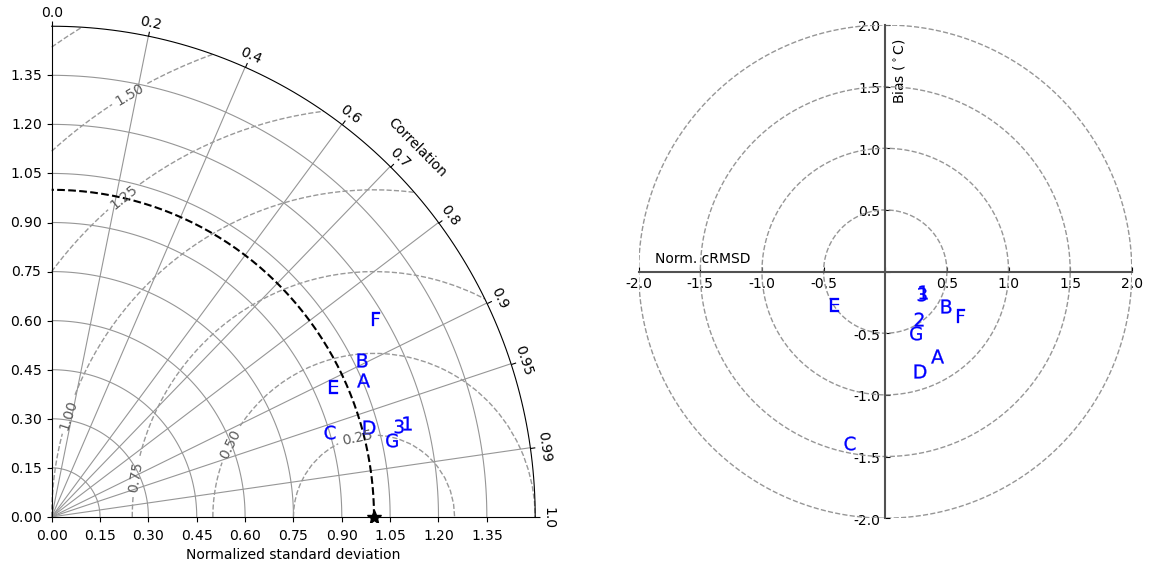

In [251]:
# fig setup
fig_dim_1 = 14
fig_dim_2 = 6.5
#plt.rcParams['figure.constrained_layout.use'] = False
#plt.subplots(layout="constrained")
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))
#fig = plt.figure(figsize=(fig_dim_1, fig_dim_2), layout="constrained")
#fig = plt.subplots(1,2, layout="constrained")


#fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))

srange=(0, 1.5)
refstd = 1 # reference std dev
rect = 121 # nrows,ncols,index
contour_levs = 7

ax = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs)



# get data and plot
for run in modelruns_info.keys():
    
    print("Taylor ", run)
    path1 = modelruns_info[run]['path']
    shortcode = modelruns_info[run]['shortcode']
    colour_m = modelruns_info[run]['colour']
    
    # plot markers
    msize = 10
    facecolor1 = colour_m
    facecolor2 = colour_m
    edgecolor1 = colour_m
    edgecolor2 = colour_m
    medgew1 = 0.2
    medgew2 = 0.2
    
    # set up markers and related options
    o_markers = {'Active Pass': {#'symbol':'1',
                             'symbol':r'$\mathdefault{A}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Cape Mudge': {#'symbol':'2',
                             'symbol':r'$\mathdefault{B}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Chrome Is.': {#'symbol':'3',
                             'symbol':r'$\mathdefault{C}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Entrance Is.': {#'symbol':'4',
                             'symbol':r'$\mathdefault{D}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Race Rocks': {#'symbol':'+',
                             'symbol':r'$\mathdefault{E}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Sheringham Pt.': {#'symbol':'x',
                             'symbol':r'$\mathdefault{F}$',
                             'size': msize, #x's look too big
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Sisters Islets': {#'symbol':'o',
                                'symbol':r'$\mathdefault{G}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             # SST / wave buoys
    #              'ptaw1': {#'symbol':'o',
    #                         'symbol':r'$\mathdefault{7}$',
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              'ptww1': {#'symbol':'D',
    #                         'symbol':"$8$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              'tcnw1': {#'symbol':'^',
    #                         'symbol':"$9$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              '46087': {#'symbol':'d',
    #                         'symbol':"$4$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
    #              '46088': {#'symbol':'H',
    #                         'symbol':"$5$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
             '46131': {#'symbol':'p',
                        'symbol':"$1$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m},
             '46146': {#'symbol':'v',
                        'symbol':"$3$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m},
    #              'neaw1': {#'symbol':'h',
    #                         'symbol':"$6$",
    #                              'size': msize,
    #                              'facecolor': facecolor2,
    #                              'edgecolor': edgecolor2,
    #                              'edgewidth': medgew2,
    #                             'labelcolor': 'b'},
             '46134': {#'symbol':'h',
                        'symbol':"$2$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m}
            }


    o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                        'Race Rocks', 'Sheringham Pt.', 'Sisters Islets',
        #                 'ptaw1', 'ptww1','tcnw1','46087','46088',
                         '46131','46146',
        #                  'neaw1',
                         '46134']
    
    

    # get data
    LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
    LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             

    var = "temperature"
    lh_stats_taylor_T_np, lh_stats_target_T_np = get_lh_stats(LH_scores, run, augment_rmse, var)
#     var = "salinity"
#     lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, run, augment_rmse, var)

    # SST buoy data
    SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
    SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

    # looks like:
    # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
    # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
    buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
    SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_T_np,buoy_stats_taylor_np))
    SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_T_np,buoy_stats_target_np))

    #Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
    #RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')
    
    ccoef = SST_taylor_np_buoys_and_LH[:,6].astype('f')
    sdev = SST_taylor_np_buoys_and_LH[:,3].astype('f')
    
    pairs_stats = []
    for i in range(len(sdev+1)):

        if i == 0:
            stn = "reference"
            sig = 1
            cc = 1
        else:
            stn = o_markerlabel[i-1]
            sig = sdev[i-1]
            cc = ccoef[i-1]

        pairs_stats.append([stn,[sig,cc]])
    
    # Add the model markers to Taylor diagram
    i = 0
    #for i, (stn, stddev, corrcoef) in enumerate(samples):
    for i, (stn, stats) in enumerate(pairs_stats):
        # avoid douvble-plotting ref
        if stn == 'reference':
            continue
        stddev = stats[0]
        corrcoef = stats[1]
        #print(corrcoef)
        
        ax.plot(np.arccos(corrcoef), 
                stddev, 
                marker=o_markers[stn]['symbol'],
                ms=o_markers[stn]['size'],
                #ms=8,
                ls='',
                #mfc=colors[i],
                #mfc=o_markers[stn]['facecolor'],
                mfc=colour_m,
                
                #mec=colors[i],
                mec=o_markers[stn]['edgecolor'],
                mew=o_markers[stn]['edgewidth'],
                #label="%d" % (i+1)),
                label=o_markerlabel[i]
               )

        
###################      
#target
# 'augment' rmse for target as per Kärnä et al 2021
# ie rmse < 0 if sig_mod - sig_obs < 0
augment_rmse = True

ax2 = plt.subplot(1,2,2)
# ax2 = read_data_and_plot_target(ax2, modelruns_info, buoy_list)

# set up axes
axismax = 2
options = {
    'ticklabcolor':'#000000',#'#808080',
    'axesedgecolor': '#525252',
    'bias_label': "Bias ($^\circ$C)",
    'RMSD_label': "Norm. cRMSD",
    'b_lab_rot': 90,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.5,
    'b_lab_pos_xoffset': 0.18,
    'rmsd_lab_pos_yoffset': 0.1,
    'rmsd_lab_pos_xoffset': -4,
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': [0.5,1,1.5,2.0], # radii of circles to draw
    #'circlelinespec':'k--',
    'circlelinespec':circlelinespec,
    'circlestyle': circlelinespec[1:], # circlelinespec by default
    'circlelinewidth': 1, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off'
}

ax2 = get_target_diagram_axes(ax2, options)

for run in modelruns_info.keys():
    print(run)
    path1 = modelruns_info[run]['path']
    shortcode = modelruns_info[run]['shortcode']
    colour_m = modelruns_info[run]['colour']

    # get data
    LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
    LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             

    var = "temperature"
    lh_stats_taylor_T_np, lh_stats_target_T_np = get_lh_stats(LH_scores, run, augment_rmse, var)
    var = "salinity"
    lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, run, augment_rmse, var)

    # SST buoy data
    SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
    #print(os.path.join(path1,SSTbuoy_pic_data)
    SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

    # looks like:
    # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
    # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
    buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
    SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_T_np,buoy_stats_taylor_np))
    SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_T_np,buoy_stats_target_np))

    Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
    RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

    # plot markers
    msize = 10
    
    facecolor1 = colour_m
    facecolor2 = colour_m
    edgecolor1 = colour_m
    edgecolor2 = colour_m
    medgew1 = 0.2
    medgew2 = 0.2

    # set up markers and related options
    o_markers = {'Active Pass': {#'symbol':'1',
                             'symbol':r'$\mathdefault{A}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Cape Mudge': {#'symbol':'2',
                             'symbol':r'$\mathdefault{B}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Chrome Is.': {#'symbol':'3',
                             'symbol':r'$\mathdefault{C}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Entrance Is.': {#'symbol':'4',
                             'symbol':r'$\mathdefault{D}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Race Rocks': {#'symbol':'+',
                             'symbol':r'$\mathdefault{E}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Sheringham Pt.': {#'symbol':'x',
                             'symbol':r'$\mathdefault{F}$',
                             'size': msize, #x's look too big
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Sisters Islets': {#'symbol':'o',
                                'symbol':r'$\mathdefault{G}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             # SST / wave buoys
#              'ptaw1': {#'symbol':'o',
#                         'symbol':r'$\mathdefault{7}$',
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              'ptww1': {#'symbol':'D',
#                         'symbol':"$8$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              'tcnw1': {#'symbol':'^',
#                         'symbol':"$9$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              '46087': {#'symbol':'d',
#                         'symbol':"$4$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              '46088': {#'symbol':'H',
#                         'symbol':"$5$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
             '46131': {#'symbol':'p',
                        'symbol':"$1$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m},
             '46146': {#'symbol':'v',
                        'symbol':"$3$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m},
#              'neaw1': {#'symbol':'h',
#                         'symbol':"$6$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
             '46134': {#'symbol':'h',
                        'symbol':"$2$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m}
            }


    o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                        'Race Rocks', 'Sheringham Pt.', 'Sisters Islets',
        #                 'ptaw1', 'ptww1','tcnw1','46087','46088',
                         '46131','46146',
        #                  'neaw1',
                         '46134']


    options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markerlabel': o_markerlabel,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': 8, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }

    ax2 = plot_target_data(ax2,RMSDs,Bs,options)




# ax2.set_in_layout(False)
# plt.tight_layout()
# plt.show()

### SSS Taylor and Target

Taylor  SalishSea1500-RUN216
SalishSea1500-RUN216


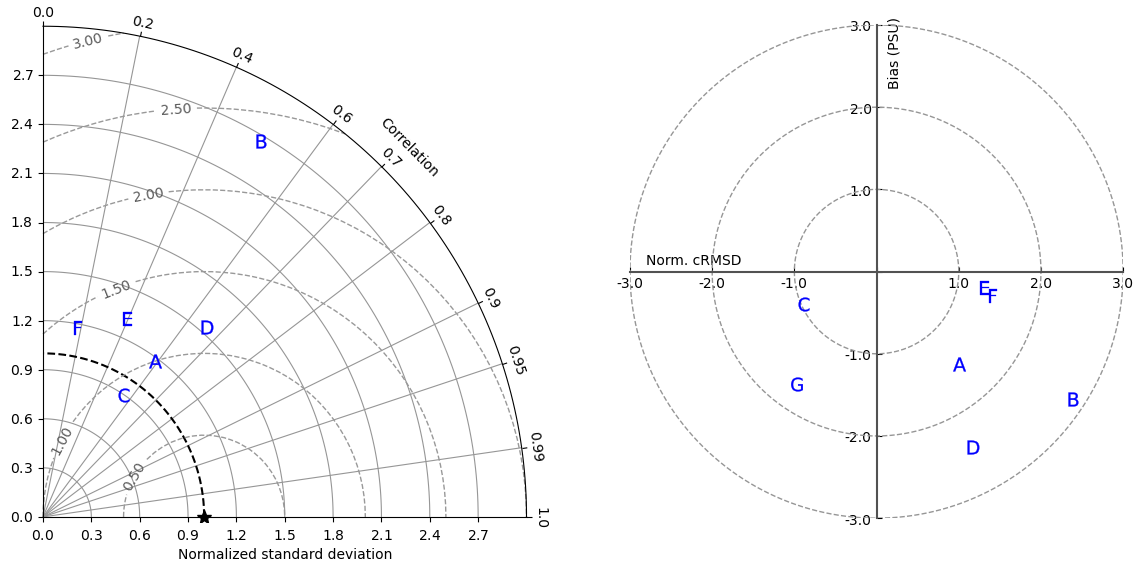

In [256]:
msize=10

o_markers = {'Active Pass': {#'symbol':'1',
                             'symbol':r'$\mathdefault{A}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Cape Mudge': {#'symbol':'2',
                             'symbol':r'$\mathdefault{B}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Chrome Is.': {#'symbol':'3',
                             'symbol':r'$\mathdefault{C}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Entrance Is.': {#'symbol':'4',
                             'symbol':r'$\mathdefault{D}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Race Rocks': {#'symbol':'+',
                             'symbol':r'$\mathdefault{E}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Sheringham Pt.': {#'symbol':'x',
                             'symbol':r'$\mathdefault{F}$',
                             'size': msize, #x's look too big
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
             'Sisters Islets': {#'symbol':'o',
                                'symbol':r'$\mathdefault{G}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': 'b'},
            }



o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                'Race Rocks', 'Sheringham Pt.', 'Sisters Islets']

markerlegend='on'
o_circles = [1,2.0, 3.0] # radii of circles to draw
axismax = 3.0
b_lab_pos_yoffset = -0.7
b_lab_pos_xoffset = 0.26
rmsd_lab_pos_yoffset = 0.1
rmsd_lab_pos_xoffset = -6
bias_label = "Bias (PSU)"

# fig setup
fig_dim_1 = 14
fig_dim_2 = 6.5
#plt.rcParams['figure.constrained_layout.use'] = False
#plt.subplots(layout="constrained")
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))
#fig = plt.figure(figsize=(fig_dim_1, fig_dim_2), layout="constrained")
#fig = plt.subplots(1,2, layout="constrained")


#fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))

srange=(0, 3.0)
refstd = 1 # reference std dev
rect = 121 # nrows,ncols,index
contour_levs = 6

ax = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs)

# get data and plot
for run in modelruns_info.keys():
    
    print("Taylor ", run)
    path1 = modelruns_info[run]['path']
    shortcode = modelruns_info[run]['shortcode']
    colour_m = modelruns_info[run]['colour']
    
    # plot markers
    msize = 10
    facecolor1 = colour_m
    facecolor2 = colour_m
    edgecolor1 = colour_m
    edgecolor2 = colour_m
    medgew1 = 0.2
    medgew2 = 0.2
    
    # get data
    LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
    LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             

#     var = "temperature"
#     lh_stats_taylor_T_np, lh_stats_target_T_np = get_lh_stats(LH_scores, run, augment_rmse, var)
    var = "salinity"
    lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, run, augment_rmse, var)


    # looks like:
    # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
    # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
#     buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
#     SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_T_np,buoy_stats_taylor_np))
#     SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_T_np,buoy_stats_target_np))

    #Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
    #RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')
    ccoef = lh_stats_taylor_S_np[:,6].astype('f')
    sdev = lh_stats_taylor_S_np[:,3].astype('f')
#     ccoef = SST_taylor_np_buoys_and_LH[:,6].astype('f')
#     sdev = SST_taylor_np_buoys_and_LH[:,3].astype('f')
    
    pairs_stats = []
    for i in range(len(sdev+1)):

        if i == 0:
            stn = "reference"
            sig = 1
            cc = 1
        else:
            stn = o_markerlabel[i-1]
            sig = sdev[i-1]
            cc = ccoef[i-1]

        pairs_stats.append([stn,[sig,cc]])
    
    # Add the model markers to Taylor diagram
    i = 0
    #for i, (stn, stddev, corrcoef) in enumerate(samples):
    for i, (stn, stats) in enumerate(pairs_stats):
        # avoid douvble-plotting ref
        if stn == 'reference':
            continue
        stddev = stats[0]
        corrcoef = stats[1]
        #print(corrcoef)
        
        ax.plot(np.arccos(corrcoef), 
                stddev, 
                marker=o_markers[stn]['symbol'],
                ms=o_markers[stn]['size'],
                ls='',
                #mfc=colors[i],
                #mfc=o_markers[stn]['facecolor'],
                mfc=colour_m,
                
                #mec=colors[i],
                mec=o_markers[stn]['edgecolor'],
                mew=o_markers[stn]['edgewidth'],
                #label="%d" % (i+1)),
                label=o_markerlabel[i]
               )
        
##################      
#target
# 'augment' rmse for target as per Kärnä et al 2021
# ie rmse < 0 if sig_mod - sig_obs < 0
augment_rmse = True

ax2 = plt.subplot(1,2,2)


# set up axes
axismax = 3
options = {
    'ticklabcolor': '#000000',#'#808080',
    'axesedgecolor': '#525252',
    'bias_label': "Bias (PSU)",
    'RMSD_label': "Norm. cRMSD",
    'b_lab_rot': 90,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.5,
    'b_lab_pos_xoffset': 0.3,
    'rmsd_lab_pos_yoffset': 0.12,
    'rmsd_lab_pos_xoffset': -6,
    
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': [1.0,2.0,3.0], # radii of circles to draw
    #'circlelinespec':'k--',
    'circlelinespec':circlelinespec,
    'circlestyle': circlelinespec[1:], # circlelinespec by default
    'circlelinewidth': 1, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off'
}

ax2 = get_target_diagram_axes(ax2, options)

for run in modelruns_info.keys():
    print(run)
    path1 = modelruns_info[run]['path']
    shortcode = modelruns_info[run]['shortcode']
    colour_m = modelruns_info[run]['colour']

    # get data
    LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
    LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             

#     var = "temperature"
#     lh_stats_taylor_T_np, lh_stats_target_T_np = get_lh_stats(LH_scores, run, augment_rmse, var)
    var = "salinity"
    lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, run, augment_rmse, var)

#     # SST buoy data
#     SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
#     #print(os.path.join(path1,SSTbuoy_pic_data)
#     SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

    # looks like:
    # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
    # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
#     buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
#     SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_T_np,buoy_stats_taylor_np))
#     SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_T_np,buoy_stats_target_np))
    Bs = lh_stats_target_S_np[:,5].astype('f')
    RMSDs =  lh_stats_target_S_np[:,4].astype('f')
#     Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
#     RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

    # plot markers
    msize = 10
    facecolor1 = colour_m
    facecolor2 = colour_m
    edgecolor1 = colour_m
    edgecolor2 = colour_m
    medgew1 = 0.2
    medgew2 = 0.2

    # set up markers and related options
    o_markers = {'Active Pass': {#'symbol':'1',
                             'symbol':r'$\mathdefault{A}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Cape Mudge': {#'symbol':'2',
                             'symbol':r'$\mathdefault{B}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Chrome Is.': {#'symbol':'3',
                             'symbol':r'$\mathdefault{C}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Entrance Is.': {#'symbol':'4',
                             'symbol':r'$\mathdefault{D}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Race Rocks': {#'symbol':'+',
                             'symbol':r'$\mathdefault{E}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Sheringham Pt.': {#'symbol':'x',
                             'symbol':r'$\mathdefault{F}$',
                             'size': msize, #x's look too big
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             'Sisters Islets': {#'symbol':'o',
                                'symbol':r'$\mathdefault{G}$',
                             'size': msize,
                             'facecolor': facecolor1,
                             'edgecolor': edgecolor1,
                             'edgewidth': medgew1,
                            'labelcolor': colour_m},
             # SST / wave buoys
#              'ptaw1': {#'symbol':'o',
#                         'symbol':r'$\mathdefault{7}$',
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              'ptww1': {#'symbol':'D',
#                         'symbol':"$8$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              'tcnw1': {#'symbol':'^',
#                         'symbol':"$9$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              '46087': {#'symbol':'d',
#                         'symbol':"$4$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
#              '46088': {#'symbol':'H',
#                         'symbol':"$5$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
             '46131': {#'symbol':'p',
                        'symbol':"$1$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m},
             '46146': {#'symbol':'v',
                        'symbol':"$3$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m},
#              'neaw1': {#'symbol':'h',
#                         'symbol':"$6$",
#                              'size': msize,
#                              'facecolor': facecolor2,
#                              'edgecolor': edgecolor2,
#                              'edgewidth': medgew2,
#                             'labelcolor': 'b'},
             '46134': {#'symbol':'h',
                        'symbol':"$2$",
                             'size': msize,
                             'facecolor': facecolor2,
                             'edgecolor': edgecolor2,
                             'edgewidth': medgew2,
                            'labelcolor': colour_m}
            }


    o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                        'Race Rocks', 'Sheringham Pt.', 'Sisters Islets',
        #                 'ptaw1', 'ptww1','tcnw1','46087','46088',
                         '46131','46146',
        #                  'neaw1',
                         '46134']


    options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markerlabel': o_markerlabel,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': 10, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }

    ax2 = plot_target_data(ax2,RMSDs,Bs,options)




### SST + SSS Taylor and Target Series

Taylor SST SalishSea1500-RUN216
Taylor SSS SalishSea1500-RUN216
Target SST SalishSea1500-RUN216
Target SSS SalishSea1500-RUN216


Text(-2.8, 3.2, '(d)')

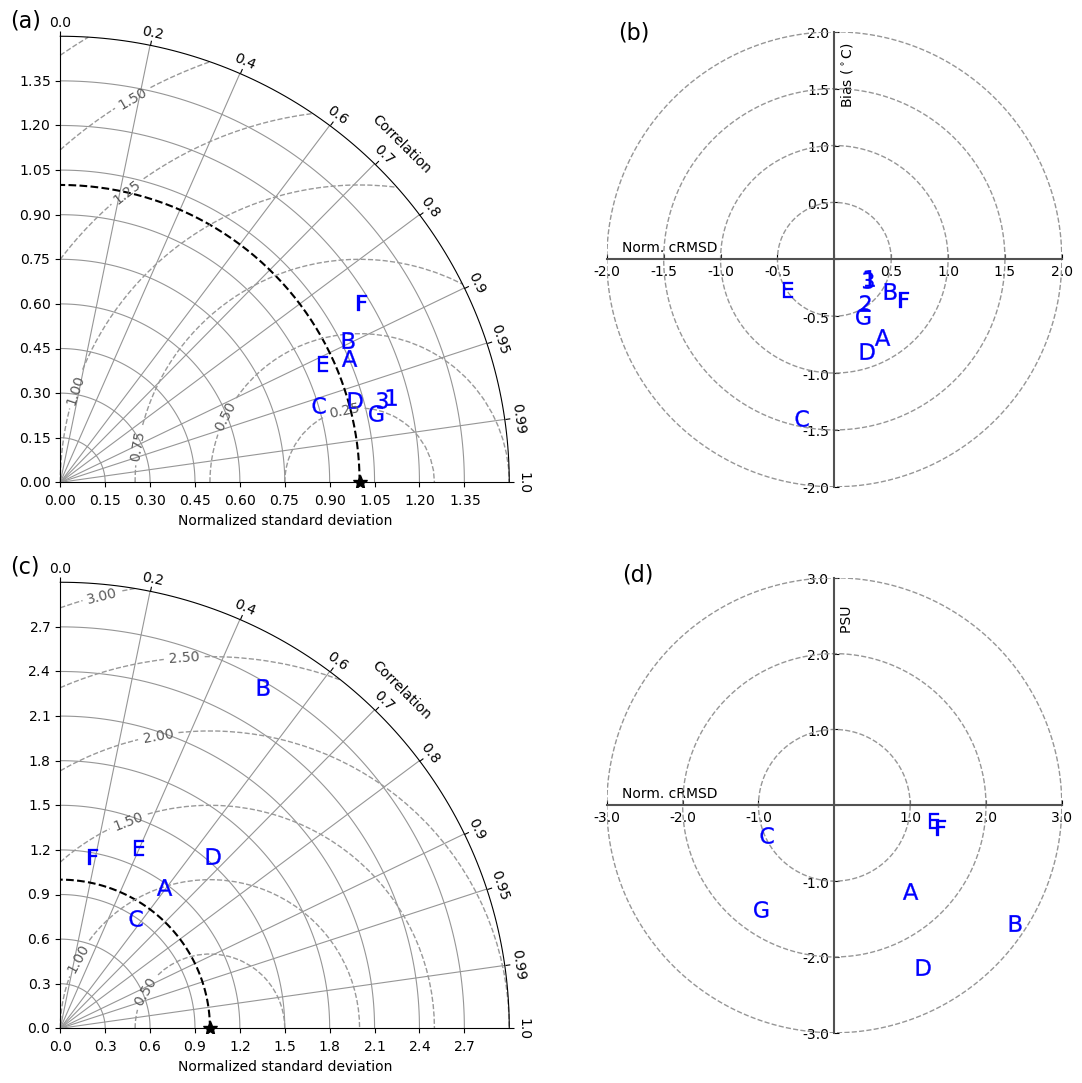

In [307]:
## streamline the above
modelruns_info = {#'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
                  #                         'colour': 'b', 
                  #                         'shortcode': 'RUN203'}, 
                     'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
                                           'colour': 'b', 
                                           'shortcode': 'RUN216'}
                 }

buoy_list = ['46131', '46134', '46146'] # excluding many of these

msize = 12

# set up markers and related options
o_markers = {'Active Pass': {'symbol':r'$\mathdefault{A}$','size':msize},
         'Cape Mudge': {'symbol':r'$\mathdefault{B}$','size':msize},
         'Chrome Is.': {'symbol':r'$\mathdefault{C}$','size':msize},
         'Entrance Is.': {'symbol':r'$\mathdefault{D}$','size':msize},
         'Race Rocks': {'symbol':r'$\mathdefault{E}$','size':msize},
         'Sheringham Pt.': {'symbol':r'$\mathdefault{F}$','size':msize},
         'Sisters Islets': {'symbol':r'$\mathdefault{G}$','size':msize},
         # SST / wave buoys (others not used are ptaw1, ptww1,tcnw1,neaw1,46087,46088)
         '46131': {'symbol':"$1$",'size':msize},
         '46146': {'symbol':"$3$",'size':msize},
         '46134': {'symbol':"$2$",'size':msize}
        }

o_markerlabel = ['Active Pass', 'Cape Mudge', 'Chrome Is.', 'Entrance Is.',
                    'Race Rocks', 'Sheringham Pt.', 'Sisters Islets',
                     '46131','46146','46134']

# fig setup
#  since tight_layout and constrained layout is broken it is important
#  to get the fig w and h proportions correct else cropping occurs
fig_dim_1 = 13 #w
fig_dim_2 = 13 #h
fig = plt.figure(figsize=(fig_dim_1, fig_dim_2)) #w,h

augment_rmse = True

############################
# Taylor diagrams
############################
var = "temperature"
srange=(0, 1.5)
refstd = 1 # reference std dev
rect = 221 # nrows,ncols,index
contour_levs = 7

ax1_SST = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs)
ax1_SST = plot_taylor_data(ax1_SST,modelruns_info,var,augment_rmse,buoy_list,o_markers,o_markerlabel)
ax1_SST.text(-0.1, 1.05, '(a)', ha='left', va='top', fontsize=16, transform=ax1_SST.transAxes)

var = "salinity"
srange=(0, 3.0)
refstd = 1 # reference std dev
rect = 223 # nrows,ncols,index
contour_levs = 6
    
ax3_SSS = get_taylor_diagram_axes(fig, rect, refstd, srange, contour_levs)
ax3_SSS = plot_taylor_data(ax3_SSS,modelruns_info,var,augment_rmse,buoy_list,o_markers,o_markerlabel)
ax3_SSS.text(-0.1, 1.05, '(c)', ha='left', va='top', fontsize=16, transform=ax3_SSS.transAxes)

############################
# Target diagrams
############################

var = "temperature"
axismax = 2
ocircles_t = [0.5,1,1.5,2.0] # radii circles draw
target_ax_options = {
    'ticklabcolor':'#000000',#'#808080',
    'axesedgecolor': '#525252',
    'bias_label': "Bias ($^\circ$C)",
    'RMSD_label': "Norm. cRMSD",
    'b_lab_rot': 90,
    'rmsd_lab_rot':0,
    'b_lab_pos_yoffset': -0.5,
    'b_lab_pos_xoffset': 0.18,
    'rmsd_lab_pos_yoffset': 0.1,
    'rmsd_lab_pos_xoffset': -4,
    'axismax': axismax,
    'ticks': [],
    'xticklabelpos': [],
    'yticklabelpos': [],
    'normalized': 'off',
    'circlecols': None, #dictionary with two possible colors keys ('ticks','tick_labels') or None
    'o_circles': ocircles_t,
    #'circlelinespec':'k--',
    'circlelinespec':'k--',
    'circlestyle': '--', # aka circlelinespec[1:]
    'circlelinewidth': 1, # rcParams.get('lines.linewidth')
    'circlecolor': '#969696', #grey'
    'obsuncertainty': 0,
    'equalaxes': 'on',
    'overlay': 'off'
}

ax2_SSS = plt.subplot(2,2,2)
ax2_SSS = get_target_diagram_axes(ax2_SSS, target_ax_options)

target_m_options = {
        # markers and marker styles etc
        'axismax': axismax,
        'o_markerlabel': o_markerlabel,
        'o_markers': o_markers,
        'o_markerstyle': "font", # added by GO - "font" / "symbol"
        'o_markersize': msize, 
        'o_markersymbol': 'o', #'+','o','x','s','d','^','v','p','h','*'
        'o_markercolor': 'b',  # single color to use for all markers (Default: None)
        'o_markercolors': None, # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
    #                             or None. If None or 'markerlegend' == 'on' then
    #                             considers only the value of 'markercolor'. (Default: None)

        'o_markerlabelcolor': 'k',
        'markerdisplayed':'marker', # marker / colorbar
        'markerobs': 'none',
        'markerlegend': 'on', # on / off (actually determines whether dots or labelled points)
        'alpha': 1,
        'stylebias': '-.',
        'numberpanels': None,
        'face': None, # face colors'
        'edge': None, 
        'cmap': 'jet',
        'cmap_vmin': None,
        'cmap_vmax': None,
        'cmap_marker': 'd',
        'cmapzdata': [],
        'colframe': '#000000', # black
        'colormap': 'on',
        'labelweight': 'bold', # weight of the x/y labels ('light', 'normal', 'bold', ...)
        'locationcolorbar': 'NorthOutside', # 'NorthOutside' or 'EastOutside'
        'target_options_file':'',
        'titlecolorbar': ''  
    }

ax2_SSS = plot_target_data1(ax2_SSS,modelruns_info,var,augment_rmse, target_m_options)
ax2_SSS.text(-1.9, 2.1, '(b)', ha='left', va='top', fontsize=16)


var = "salinity"
axismax = 3

# change some options
target_ax_options['axismax'] = axismax
target_ax_options['bias_label'] = "PSU"
target_ax_options['o_circles'] = [1.0,2.0,3.0]
target_ax_options['b_lab_pos_yoffset'] = -0.7
target_ax_options['b_lab_pos_xoffset'] = 0.26
target_ax_options['rmsd_lab_pos_yoffset'] = 0.15
target_ax_options['rmsd_lab_pos_xoffset'] = -6

ax4_SSS = plt.subplot(2,2,4)
ax4_SSS = get_target_diagram_axes(ax4_SSS, target_ax_options)


target_m_options['axismax'] = axismax
ax4_SSS = plot_target_data1(ax4_SSS,modelruns_info,var,augment_rmse, target_m_options)
ax4_SSS.text(-2.8, 3.2, '(d)', ha='left', va='top', fontsize=16)


In [306]:
def plot_taylor_data(ax,modelruns_info,var,augment_rmse,buoy_list,o_markers,o_markerlabel):
    # get data and plot
    for run in modelruns_info.keys():

        if var == "temperature":
            print("Taylor SST", run)
        elif var == "salinity":
            print("Taylor SSS", run)
        else:
            print("No variable chosen")
            break

        path1 = modelruns_info[run]['path']
        shortcode = modelruns_info[run]['shortcode']
        colour_m = modelruns_info[run]['colour']

        # plot markers
        facecolor1 = colour_m
        facecolor2 = colour_m
        edgecolor1 = colour_m
        edgecolor2 = colour_m
        medgew1 = 0.2
        medgew2 = 0.2

        # get lighthouse data
        LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
        LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             

        # to do - am returning data for target unnecessarily - modify get_lh_stats into 2 functions
        lh_stats_taylor_np, lh_stats_target_np = get_lh_stats(LH_scores, run, augment_rmse, var)

        if var == "temperature":
            # SST buoy data
            SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
            SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

            # looks like:
            # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
            # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
            buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
            SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_np,buoy_stats_taylor_np))

            ccoef = SST_taylor_np_buoys_and_LH[:,6].astype('f')
            sdev = SST_taylor_np_buoys_and_LH[:,3].astype('f')

        elif var == "salinity":
            lh_stats_taylor_S_np, lh_stats_target_S_np = get_lh_stats(LH_scores, run, augment_rmse, var)

            ccoef = lh_stats_taylor_S_np[:,6].astype('f')
            sdev = lh_stats_taylor_S_np[:,3].astype('f')

        pairs_stats = []
        for i in range(len(sdev+1)):
            if i == 0:
                stn = "reference"
                sig = 1
                cc = 1
            else:
                stn = o_markerlabel[i-1]
                sig = sdev[i-1]
                cc = ccoef[i-1]
            pairs_stats.append([stn,[sig,cc]])

        # Add the model markers to Taylor diagram
        i = 0
        for i, (stn, stats) in enumerate(pairs_stats):
            # avoid douvble-plotting ref
            if stn == 'reference':
                continue
            stddev = stats[0]
            corrcoef = stats[1]
            #print(corrcoef)

            ax.plot(np.arccos(corrcoef), 
                    stddev, 
                    marker=o_markers[stn]['symbol'],
                    ms=o_markers[stn]['size'],
                    ls='',
                    #mfc=colors[i],
                    #mfc=o_markers[stn]['facecolor'],
                    mfc=colour_m,
                    #mec=colors[i],
                    mec=edgecolor1,
                    mew=medgew1,
                    #label="%d" % (i+1)),
                    label=o_markerlabel[i]
                   )
            

    return ax
            
            
def plot_target_data1(ax,modelruns_info,var,augment_rmse, options):


    # loop over model runs, add data
    for run in modelruns_info.keys():
      
        if var == "temperature":
            print("Target SST", run)
        elif var == "salinity":
            print("Target SSS", run)
        else:
            print("No variable chosen")
            break
    
        path1 = modelruns_info[run]['path']
        shortcode = modelruns_info[run]['shortcode']
        colour_m = modelruns_info[run]['colour']
        
        # markers
        facecolor1 = colour_m
        facecolor2 = colour_m
        edgecolor1 = colour_m
        edgecolor2 = colour_m
        medgew1 = 0.2
        medgew2 = 0.2
        

        # get lighthouse data
        LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
        LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))             
        lh_stats_taylor_np, lh_stats_target_np = get_lh_stats(LH_scores, run, augment_rmse, var)
        
        # if temp, then use buoys otherwise just lh data
        if var == "temperature":
             # SST buoy data
            SSTbuoy_pic_data = "SST_class4_" + run + ".pickle"
            #print(os.path.join(path1,SSTbuoy_pic_data)
            SSTbuoy_scores = pickle.load(open(os.path.join(path1,SSTbuoy_pic_data), 'rb'))

            # looks like:
            # SSTbuoy_scores['SalishSea1500-RUN203']['ptaw1']['filt_interp_data']['scores'].keys()
            # dict_keys(['skill1981', 'mean_obs', 'mean_mod', 'bias', 'crmse', 'gamma2', 'rmse', 'mae', 'mad', 'pearson', 'stdev_obs', 'stdev_mod'])
            buoy_stats_taylor_np, buoy_stats_target_np = get_SSTbuoy_stats(SSTbuoy_scores, run, augment_rmse, buoy_list)
            SST_taylor_np_buoys_and_LH = np.concatenate((lh_stats_taylor_np,buoy_stats_taylor_np))
            SST_target_np_buoys_and_LH = np.concatenate((lh_stats_target_np,buoy_stats_target_np))

            Bs = SST_target_np_buoys_and_LH[:,5].astype('f')
            RMSDs =  SST_target_np_buoys_and_LH[:,4].astype('f')

        elif var == "salinity":
            Bs = lh_stats_target_np[:,5].astype('f')
            RMSDs =  lh_stats_target_np[:,4].astype('f')

        ax = plot_target_data2(ax,RMSDs,Bs,options, facecolor1, edgecolor1, medgew1)
        
    return ax

def plot_target_data2(ax,RMSDs,Bs,options, facecolor1, edgecolor1, medgew1):

    x = RMSDs
    y = Bs 
    
    # Set font and marker size
    fontSize = matplotlib.rcParams.get('font.size') 

    o_markerlabel = options['o_markerlabel']
    o_markers = options['o_markers']
    o_markerstyle = options['o_markerstyle'] # added by GO - "font" / "symbol"
    o_markersize = options['o_markersize']
    o_markersymbol = options['o_markersymbol'] #'+','o','x','s','d','^','v','p','h','*'
    o_markercolor = options['o_markercolor'] # single color to use for all markers (Default: None)
    o_markercolors = options['o_markercolors'] # if None, considers 'markercolor' only; dictionary with two colors as keys ('face', 'edge')
#                             or None. If None or 'markerlegend' == 'on' then
#                             considers only the value of 'markercolor'. (Default: None)
    o_markerlabelcolor = options['o_markerlabelcolor']
    markerdisplayed = options['markerdisplayed']
    markerobs = options['markerobs']
    markerlegend = options['markerlegend']
    alpha = options['alpha']
    stylebias = options['stylebias']
    numberpanels = options['numberpanels']
    face = options['face']
    edge = options['edge']
    cmap = options['cmap']
    cmap_vmin = options['cmap_vmin']
    cmap_vmax = options['cmap_vmax']
    cmap_marker = options['cmap_marker']
    cmapzdata = options['cmapzdata']
    colframe = options['colframe']
    colormap = options['colormap']
    labelweight = options['labelweight']
    locationcolorbar = options['locationcolorbar']
    axismax = options['axismax']
    
    target_options_file = options['target_options_file']
    titlecolorbar = options['titlecolorbar']

    # Check enough labels provided if markerlabel provided. Not a problem if labels
    # provided via the markers option.
    numberLabel = len(o_markerlabel)
    if numberLabel > 0:
        if isinstance(o_markerlabel, list) and numberLabel < len(RMSDs):
            raise ValueError('Insufficient number of marker labels provided.\n' +
                             'target: No. labels=' + str(numberLabel) + ' < No. markers=' +
                             str(len(RMSDs)) + '\n' +
                             'taylor: No. labels=' + str(numberLabel+1) + ' < No. markers=' +
                             str(len(RMSDs)+1))
        elif isinstance(o_markerlabel, dict) and numberLabel > 70: # what is this? GLO why 70?
            raise ValueError('Insufficient number of marker labels provided.\n' +
                             'target: No. labels=' + str(numberLabel) + ' > No. markers= 70')

    if markerlegend == 'on':
        # Check that marker labels have been provided
        if o_markerlabel == '' and o_markers == None:
            raise ValueError('No marker labels provided.')

        # Plot markers of different color and symbols with labels displayed in a legend
        limit = axismax
        hp = ()
        rgba = None

        if o_markers is None:

            # Define default markers (function)
    #         marker, markercolor = get_default_markers(X, option)
            #get_default_markers:
    #         alpha = option['alpha']

            # Define list of marker symbols and colros
            kind = ['+','o','x','s','d','^','v','p','h','*']
            colorm = ['r','b','g','c','m','y','k','gray']
            if len(RMSDs) > 80:
                print('You must introduce new markers to plot more than 70 cases.')
                print('The ''marker'' character array need to be extended inside the code.')

            if len(RMSDs) <= len(kind):
                # Define markers with specified color
                marker = []
                markercolor = []
                if o_markercolor is None:
                    for i, color in enumerate(colorm):
                        rgba = clr.to_rgb(color) + (alpha,)
                        marker.append(kind[i] + color)
                        markercolor.append(rgba)
                else:
                    rgba = clr.to_rgb(o_markercolor) + (alpha,)
                    for symbol in kind:
                        marker.append(symbol + o_markercolor)
                        markercolor.append(rgba)
            else:
                # Define markers and colors using predefined list
                marker = []
                markercolor = []
                for color in colorm:
                    for symbol in kind:
                        marker.append(symbol + color)
                        rgba = clr.to_rgb(color) + (alpha,)
                        markercolor.append(rgba)
            # END get_default_markers


            # Plot markers at data points
            labelcolor = []
            markerlabel = []
            for i, xval in enumerate(RMSDs):
                if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                    h = ax.plot(RMSDs[i],
                                Bs[i],
                                marker[i], 
                                markersize = o_markersize,
                                markerfacecolor = markercolor[i],
                                markeredgecolor = markercolor[i][0:3] + (1.0,),
                                markeredgewidth = 1)
                    hp += tuple(h)
                    labelcolor.append(o_markerlabelcolor)
                    markerlabel.append(o_markerlabel[i])

        # if there's an o_markers dictionary
        else:
            # Obtain markers from option['markers']
            #labels, labelcolor, marker, markersize, markerfacecolor, markeredgecolor = \
                #get_single_markers(option['markers'])

            #get_single_markers -->
            if o_markers is None:
                raise ValueError("Empty dictionary provided for option['markers']")

            labelcolor = []
            marker = []
            markerfacecolor = []
            markeredgecolor = []
            markerlabel = []
            markersize = []
            markeredgewidth = []

    #         if o_markerstyle == "font":
    #             marker_style.update(markeredgecolor="none", markersize=15)

            # Iterate through keys in dictionary
            for key in o_markers:
#                 color = o_markers[key]['facecolor']
                color = facecolor1
                symbol = o_markers[key]['symbol']

                if o_markerstyle != "font":
                    SymbolColor = symbol + color
                    marker.append(SymbolColor)
                else:
                    marker.append(symbol)
                    fontFamily = rcParams.get('font.family')

                markersize.append(o_markers[key]['size'])
#                 markerfacecolor.append(color)
                markerfacecolor.append(facecolor1)
#                 markeredgecolor.append(o_markers[key]['edgecolor'])
                markeredgecolor.append(edgecolor1)
#                 markeredgewidth.append(o_markers[key]['edgewidth'])
                markeredgewidth.append(medgew1)
                markerlabel.append(key) # store label
#                 labelcolor.append(o_markers[key]['labelcolor'])
                labelcolor.append(facecolor1)
                
            # end get_single_markers

            # Plot markers at data points
            for i, xval in enumerate(RMSDs):
                if abs(RMSDs[i]) <= limit and abs(Bs[i]) <= limit:
                    h = ax.plot(RMSDs[i],
                                Bs[i],
                                marker=marker[i],
                                markersize = markersize[i],
                                markerfacecolor = markerfacecolor[i],
                                markeredgecolor = markeredgecolor[i],
                                markeredgewidth = markeredgewidth[i])
                    hp += tuple(h)
                    #markerlabel.append(labels[i])

    else:
        # Plot markers as dots of a single color with accompanying labels
        limit = axismax

        # Define edge and face colors of the markers
        #                                             default_key, dict_key, key_key
        #edge_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'edge')
        # get_from_dict_or_default ->
        if o_markercolors is None:
            edge_color = o_markercolor
        elif edge is None:
            edge_color = o_markercolor
        elif edge != None:
            edge_color = edge
        # end get_from_dict_or_default

        if edge_color is None: edge_color = 'r'

        #face_color = get_from_dict_or_default(option, 'markercolor', 'markercolors', 'face')
        # get_from_dict_or_default ->
        if o_markercolors is None:
            face_color = o_markercolor
        elif face is None:
            face_color = o_markercolor
        elif face != None:
            face_color = face
        # end get_from_dict_or_default

        if face_color is None: face_color = edge_color
        face_color = clr.to_rgb(face_color) + (alpha,)

        labelcolor = []
        for i in range(len(RMSDs)):
            xval, yval = RMSDs[i], Bs[i]
            if abs(xval) <= limit and abs(yval) <= limit:
                ax.plot(xval, yval, o_markersymbol,markersize=o_markersize, markerfacecolor=face_color,markeredgecolor=edge_color)
                labelcolor.append(o_markerlabelcolor)

                # Check if marker labels provided
                if type(o_markerlabel) is list:
                    # Label marker
                    ax.text(xval, yval, o_markerlabel[i],color=o_markerlabelcolor,verticalalignment='bottom',horizontalalignment='right',fontsize=fontSize)

            del i, xval, yval
            
    return ax

In [270]:
circlelinespec[1:]


'--'